## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# check for missing values
df = pd.read_csv(
    '../data/course_lead_scoring.csv'
)

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
# define categorical and numerical features depending on the data types
categorical_features = [
    'lead_source',
    'industry',
    'employment_status',
    'location',
]

numerical_features = [
    'number_of_courses_viewed',
    'annual_income',
    'interaction_count',
    'lead_score',
]

In [5]:
# substitute missing values with 'NA' for categorical features
df[categorical_features] = df[categorical_features].fillna('NA')
# substitute missing values with 0.0 for numerical features
df[numerical_features] = df[numerical_features].fillna(0.0)
df.head()


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
info_df = pd.DataFrame([df.isnull().sum(), df.dtypes])
info_df = info_df.T
info_df.columns = ['missing_values', 'dtype']
info_df

,missing_values,dtype
lead_source,0,object
industry,0,object
number_of_courses_viewed,0,int64
annual_income,0,float64
employment_status,0,object
location,0,object
interaction_count,0,int64
lead_score,0,float64
converted,0,int64


In [84]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.converted
y_val = df_val.converted
y_test = df_test.converted

df_train.drop(columns=['converted'], inplace=True)
df_val.drop(columns=['converted'], inplace=True)
df_test.drop(columns=['converted'], inplace=True)



### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [78]:
from sklearn.metrics import roc_auc_score

for feature in numerical_features:
    auc = roc_auc_score(y_train, df_train[feature])
    print(f"{feature}: {auc}")



number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


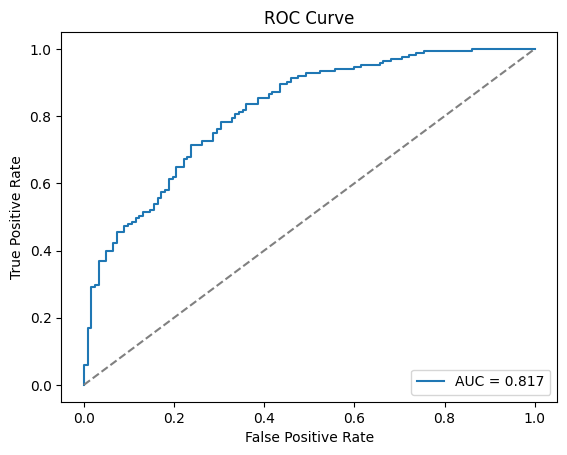

In [ ]:
# in this case no scaling is applied
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# if used lbfgs solver, the model outputed 0.92 AUC score
# model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=10000)

model = LogisticRegression(C=1.0, solver='liblinear', max_iter=100)
model.fit(X=X_train, y=y_train)

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_val_pred = model.predict_proba(X=X_val)[:,1]

fpr, tpr, thresholds  = roc_curve(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


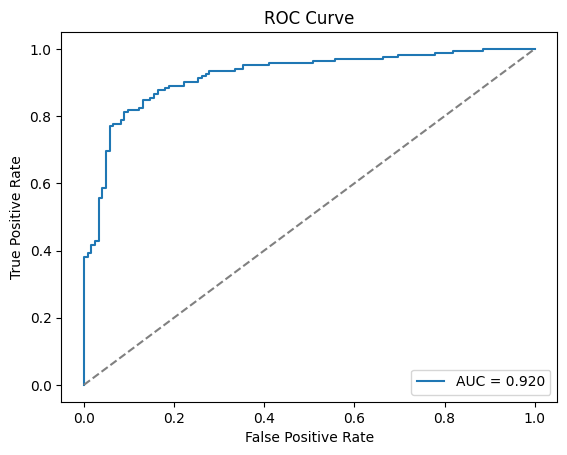

In [125]:
# a try with scaling as mentioned in the chat
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
dv = DictVectorizer(sparse=False)

def preprocess_data(df_raw, dv, scl):
    df_cat = df_raw[categorical_features].to_dict(orient='records')
    df_num = scl.fit_transform(df_raw[numerical_features])
    X_cat = dv.fit_transform(df_cat)
    X_num = scl.fit_transform(df_num)
    X = np.column_stack([X_cat, X_num])
    return X

X_train = preprocess_data(df_train, dv, scl)
X_val = preprocess_data(df_val, dv, scl)

model = LogisticRegression(C=1.0, solver='liblinear', max_iter=100)
model.fit(X=X_train, y=y_train)

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_val_pred = model.predict_proba(X=X_val)[:,1]

fpr, tpr, thresholds  = roc_curve(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745


np.float64(0.64)

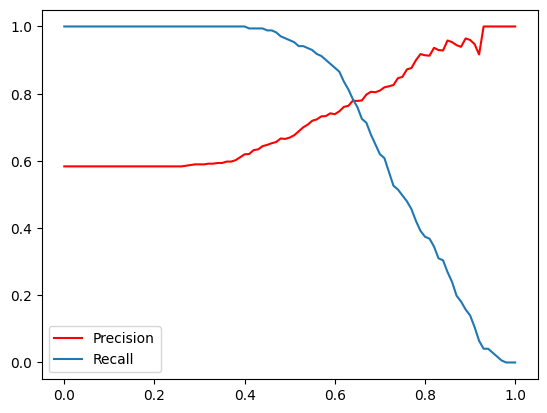

In [81]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(C=1.0, solver='liblinear', max_iter=100)
model.fit(X=X_train, y=y_train)

y_val_pred = model.predict_proba(X=X_val)[:,1]

thresholds = np.linspace(start=0.0, stop=1.0, num=101)

score_by_threshold = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predicted_positive = (y_val_pred >= t)
    predicted_negative = (y_val_pred < t)

    tp = (predicted_positive & actual_positive).sum()
    tn = (predicted_negative & actual_negative).sum()

    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.true_divide(tp, tp + fp)
        precision = np.nan_to_num(precision, nan=1.0)
        recall = np.true_divide(tp, tp + fn)
        recall = np.nan_to_num(recall)
        
        score_by_threshold.append((t, precision, recall))

score_by_threshold = pd.DataFrame(score_by_threshold, columns=['thresholds', 'precission', 'recall'])
# score_by_threshold

from matplotlib import pyplot as plt

plt.plot(score_by_threshold['thresholds'], score_by_threshold['precission'], label='Precision', color='red')
plt.plot(score_by_threshold['thresholds'], score_by_threshold['recall'], label='Recall')
# plt.figure(figsize=(5, 5))
plt.legend()


diff = np.array(score_by_threshold['precission'] - score_by_threshold['recall'])
cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
thresholds[min(cross_idx)]

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


57    0.57
Name: thresholds, dtype: float64

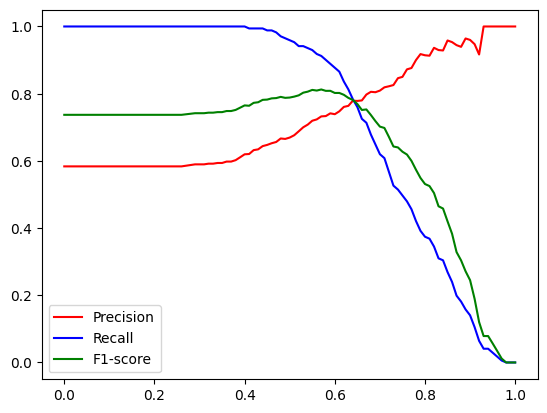

In [82]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(C=1.0, solver='liblinear', max_iter=100)
model.fit(X=X_train, y=y_train)

y_val_pred = model.predict_proba(X=X_val)[:,1]

thresholds = np.linspace(start=0.0, stop=1.0, num=101)

score_by_threshold = []
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predicted_positive = (y_val_pred >= t)
    predicted_negative = (y_val_pred < t)

    tp = (predicted_positive & actual_positive).sum()
    tn = (predicted_negative & actual_negative).sum()

    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.true_divide(tp, tp + fp)
        precision = np.nan_to_num(precision, nan=1.0)
        recall = np.true_divide(tp, tp + fn)
        recall = np.nan_to_num(recall)
        
        f1 = 2 * np.true_divide(precision*recall, precision+recall)

        score_by_threshold.append((t, precision, recall, f1))

score_by_threshold = pd.DataFrame(score_by_threshold, columns=['thresholds', 'precission', 'recall', 'f1'])
# score_by_threshold

from matplotlib import pyplot as plt

plt.plot(score_by_threshold['thresholds'], score_by_threshold['precission'], label='Precision', color='red')
plt.plot(score_by_threshold['thresholds'], score_by_threshold['recall'], label='Recall', color='blue')
plt.plot(score_by_threshold['thresholds'], score_by_threshold['f1'], label='F1-score', color='green')
plt.legend()

threshold_value_f1_max =score_by_threshold.thresholds[score_by_threshold['f1'] == max(score_by_threshold['f1'])]
threshold_value_f1_max

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36


In [116]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score

def train_model(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model 

def predict_y(dv, model, df_predict):
    dicts = df_predict.to_dict(orient='records')
    X_predict = dv.transform(dicts)
    y_pred = model.predict_proba(X_predict)[:,1]

    return y_pred

kf = KFold(n_splits=5, shuffle=True, random_state=1)

fold_spec = []
for train, test in kf.split(df_full_train):
    df_train_k = df_full_train.iloc[train]
    df_val_k = df_full_train.iloc[test]

    y_train_k = df_train_k.converted
    df_train_k = df_train_k.drop(columns=['converted'])

    y_val_k = df_val_k.converted
    df_val_k = df_val_k.drop(columns=['converted'])


    dv, model = train_model(df_train_k, y_train_k) 

    y_val_pred = predict_y(dv, model, df_val_k)

    roc_score_k = roc_auc_score(y_val_k, y_val_pred)

    fold_spec.append((roc_score_k))

round(np.std(fold_spec), 3)
   

np.float64(0.036)

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [120]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score

def train_model(df_train, y_train, regularization_parameter=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=regularization_parameter, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model 

def predict_y(dv, model, df_predict):
    dicts = df_predict.to_dict(orient='records')
    X_predict = dv.transform(dicts)
    y_pred = model.predict_proba(X_predict)[:,1]

    return y_pred

kf = KFold(n_splits=5, shuffle=True, random_state=1)
regularization_parameters = [0.000001, 0.001, 1]

fold_spec = []
for regularization_parameter in regularization_parameters:
    for train, test in kf.split(df_full_train):
        df_train_k = df_full_train.iloc[train]
        df_val_k = df_full_train.iloc[test]

        y_train_k = df_train_k.converted
        df_train_k = df_train_k.drop(columns=['converted'])

        y_val_k = df_val_k.converted
        df_val_k = df_val_k.drop(columns=['converted'])


        dv, model = train_model(df_train_k, y_train_k, regularization_parameter) 

        y_val_pred = predict_y(dv, model, df_val_k)

        roc_score_k = roc_auc_score(y_val_k, y_val_pred)

        fold_spec.append((regularization_parameter, roc_score_k))
    

# round(np.std(fold_spec), 3)
fold_spec_df = pd.DataFrame(fold_spec, columns=['regularization_parameter', 'roc_score'])
fold_spec_df

fold_spec_df.groupby('regularization_parameter').agg({'roc_score': ['mean', 'std']})

roc_score          
                              mean       std
regularization_parameter                    
0.000001                  0.560208  0.026607
0.001000                  0.866878  0.032139
1.000000                  0.822109  0.040034



## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one